# Initial Access in 5G
This tutorial will introduce the audience to initial access procedure and downlink synchronization in 5G networks. The initial access incapsulate the following components:

- Master Information Block (MIB)
- Physical Broadcast Channel (PBCH)
- Synchronization Signal Block (SSB):
    - Primary Synchronization Signal (PSS)
    - Secondary Synchronization Signal (SSS)
    - PBCH payload
    - Demodulation Reference Signal (DMRS) for PBCH
- Time Synchronization
- Frequency Synchronization

This content covers following topics:

- [Import Libraries](#Import-Libraries)
    - [External Libaries](#External-Libaries)
    - [5G Toolkit Modules](#5G-Toolkit-Modules)
- [System Parameters](#System-Parameters)
- [PBCH Information](#PBCH-Information)
- [Transmission-side Processing](#Transmission-side-Processing)
    - [Generate Primary Synchronization Sequence](#Generate-Primary-Synchronization-Sequence)
    - [Generate Secondary Synchronization Sequence (SSS)](#Generate-Secondary-Synchronization-Sequence-(SSS))
    - [Generate Demodulation Reference Sequence (DMRS)](#Generate-Demodulation-Reference-Sequence-(DMRS))
    - [Generate the PBCH Payload](#Generate-the-PBCH-Payload)
    - [Construct SSB Grid](#Construct-SSB-Grid)
    - [Mapping SSB to Transmission Grid for ODFM](#Mapping-SSB-to-Transmission-Grid-for-ODFM)
    - [OFDM Modulator](#OFDM-Modulator)
    - [Analog Beamforming](#Analog-Beamforming)
- [Channel Generation](#Channel-Generation)
- [Pass Tx signal through Wireless Channel](#Pass-Tx-signal-through-Wireless-Channel)
- [Noise addition at receiver](#Noise-addition-at-receiver)
- [SSB Receiver Side](#SSB-Receiver-Side)
    - [Receiver combining](#Receiver-combining)
    - [PSS Detection: largest peak](#PSS-Detection:-largest-peak)
    - [Largest peak](#Largest-peak)
    - [OFDM Demodulation: Resource Grid reconstruction](#OFDM-Demodulation-Resource-Grid-reconstruction)
    - [SSB Extaction from Resource Grid](#SSB-Extaction-from-Resource-Grid)
    - [Extracted SSB](#Extracted-SSB)
    - [Comparing Transmitted and Received SSB Grid](#Comparing-Transmitted-and-Received-SSB-Grid)
    - [Spectrum Analysis](#Spectrum-Analysis)
    - [(SSS Detection: PSS channel assisted) + Cell-ID estimation](#(SSS-Detection:-PSS-channel-assisted)-+-Cell-ID-estimation)
    - [DMRS Parameters Detection + DMRS Sequence Generation](#DMRS-Parameters-Detection-+-DMRS-Sequence-Generation)
    - [Channel Estimation and PBCH Symbol Equalization](#Channel-Estimation-and-PBCH-Symbol-Equalization)
    - [PBCH Decoding](#PBCH-Decoding)
    - [Information Aggregation](#Information-Aggregation)
- [Performance Evaluations: BER + Cell-IDs + DMRS Parameter Detection](#Performance-Evaluations:-BER-+-Cell-IDs-+-DMRS-Parameter-Detection)
    - [Cell-IDs Detection](#Cell-IDs-Detection)
    - [DMRS Parameter Detection](#DMRS-Parameter-Detection)
    - [BER computation](#BER-computation)


## Import Libraries
### External Libaries

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np

### 5G Toolkit Modules

In [2]:

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.ChannelProcessing  import ApplyChannel, AddNoise
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## System Parameters

In [3]:
## System Parameters
carrierFrequency = 3.6*10**9        # Carrier frequency 3.6 GHz
scs         = 30*(10**3);           # Subcarrier spacing for simulation
bandwidthTx = 10*(10**6);           # Transmission bandwidth
nSymbolFrame= 140*int(scs/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(bandwidthTx, scs)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.N_RB        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

## Number of batches | Number of Transmitter | Number of Receivers | 
## Number of Symbols | Number of Tx-Antennas | Number of Rx-Antennas
numUEs      = 1      # Number of UE condsidered for Simulation
Nr_x        = 2      # Number of antennas placed Horizontally at Receiver (2D Antenna Panels)
Nr_y        = 2      # Number of antennas placed Vertically   at Receiver (2D Antenna Panels)
Pr          = 2      # Polarization of Receiver antennas

numBSs      = 1      # Number of BSs condsidered for Simulation
Nt_x        = 8      # Number of antennas placed Horizontally at Transmitter (2D Antenna Panels)
Nt_y        = 8      # Number of antennas placed Vertically   at Transmitter (2D Antenna Panels)
Pt          = 2      # Polarization of Transmitter antennas
 
nBatch      = 1      # Number of Batches considerd for Simulations (Similar to Monte-carlo)

## PBCH Information
PBCH information consists of MIB and Additional Timing Information (ATI)

|Parameters | Defining | MIB | ATI
| :--- | :--- | :--- | :---
|systemFrameNumber | SFN Consists of 10 Bits and the 6 most significant bits (MSB) of the 10-bit System Frame Number (SFN) are defined in MIB. | 6 | 4
|subCarrierSpacingCommon | subcarrier spacing for SIB1, Msg2, Msg4 for initial access, paging, and broadcast SI-messages.| 1 | 0 
|ssbSubCarrierOffset | Frequency domain offset between SSB and the overall resource block grid in number of subcarriers | 4-5 | 0 
|DMRSTypeAPosition | Indicates the position of (first) DM-RS for downlink and uplink when using ‘Mapping Type A’ | 1 | 0
|controlResourceSet0 | Determines a common ControlResourceSet (CORESET), a common search space and necessary PDCCH parameters. | 4 | 0 
|searchSpace0 | Indicates that SIB1 is present, the field pdcch-ConfigSIB1 indicates the frequency positions where the UE may find SS/PBCH block with SIB1. | 4 | 0 
|cellBarred | Indicates whether the current cell is barred. This field is ignored by IAB-MT. In LTE this information was provided in SIB1 | 1 | 0
|intraFrequencyReselection | Controls cell selection/reselection to intra-frequency cells when the highest ranked cell is barred, or treated as barred by the UE. | 1 | 0
|SSB Index | Indicates the index of the SSB in the group of $\text{L}_\text{max}$ SSBs transmitted in a half frame. | 0-3 | 0
|Spare Bit | Unused | 1 | 0

In [4]:
lamda                           = 3e8/carrierFrequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(carrierFrequency, nSCSOffset)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________

## Transmission-side Processing
- Generate the PSS
- Generate the SSS
- Generate the PBCH
- Generate the DMRS-PBCH
- Load the above information into **Synchronization Signal Block** (SSB)
- Insert the SSB into Resource Grid
- Load Resource Grid into Transmission Grid
- **OFDM** Modulation
- **Analog Beamforming**


| |
|:--:| 
| |
| ![SSB Tranmitter side](images/PBCHTransmitter.png)| 
| *Transmitter side implementation of SSB*|


### Generate Primary Synchronization Sequence (PSS)
- Inputs: Cell ID-2 ($\text{N}_\text{ID}^\text{2}$): ``N_ID2``
- Object for generating PSS sequence: ``pssObject``
- PSS Sequence: ``pssSequence``

In [5]:
N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

### Generate Secondary Synchronization Sequence (**SSS**)
- Inputs: 
    - Cell ID-1 ($\text{N}_\text{ID}^\text{1}$): ``N_ID1``
    - Cell ID-2 ($\text{N}_\text{ID}^\text{2}$): ``N_ID2``
- Object for generating SSS sequence: ``sssObject``
- PSS Sequence: ``sssSequence``

In [6]:
N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

### Generate Demodulation Reference Sequence (**DMRS**)
- Inputs: 
    - Cell ID ($\text{N}_\text{ID} = 3 \times \text{N}_\text{ID}^\text{1} + \text{N}_\text{ID}^\text{2}$): ``N_ID``
    - SSB Index ($\text{i}_\text{SSB}$): ``ssbIndex``
    - Maximum SSBs in a half frame ($\text{L}_\text{max}$): ``nssbCandidatesInHrf``
    - Half frame bit ($\text{n}_\text{HF}$): ``hrfBit``
- Object for generating DMRS sequence: ``dmrsObject``
- DMRS Sequence: ``dmrsSequence``

In [7]:
# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)

### Generate the PBCH Payload
- Inputs: 
    - Carrier frequency ($f_c$):``carrierFrequency``
    - Choice bit: ``choiceBit``
    - Subcarrier spacing common ($\Delta f$): ``subCarrierSpacingCommon``
    - DMRS TypeA-Position: ``DMRSTypeAPosition``
    - Control ResourceSet0: ``controlResourceSet0``
    - Search Space0: ``searchSpace0``
    - cell Barred flag: ``cellBarred``
    - intraFrequencyReselection: ``intraFrequencyReselection``
    - System Frame Number: ``systemFrameNumber``
    - ssbSubCarrierOffset ($k_{ssb}$): ``ssbSubCarrierOffset``
    - Half frame bit ($\text{n}_\text{HF}$): ``hrfBit``
    - SSB Index ($\text{i}_\text{SSB}$): ``ssbIndex``
    - Cell ID ($\text{N}_\text{ID}$): ``N_ID``
    - Maximum SSBs in a half frame ($\text{L}_\text{max}$): ``nssbCandidatesInHrf``
- Object for generating PBCH symbols: ``pbchObject``
- PBCH symbols: ``pbchSymbols``

Implementation of PBCH is detailed below:


![](images/PBCHChain.svg)


In [8]:
# Generate PBCH symbols
pbchObject   = PBCH(carrierFrequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition, 
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID, 
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Constellation Diagram: Tx

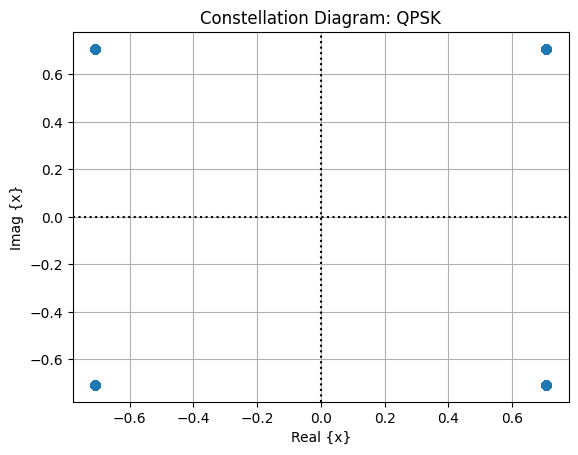

In [9]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols), np.imag(pbchSymbols))
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

### Construct SSB Grid
- Parameters: 
    - Cell ID ($\text{N}_\text{ID}$): ``N_ID``
- Object for generating PBCH symbols: ``ssbObject``
    - Inputs
        - pssSequence, 
        - sssSequence, 
        - dmrsSequence, 
        - pbchSymbols
- PBCH symbols: ``ssb``

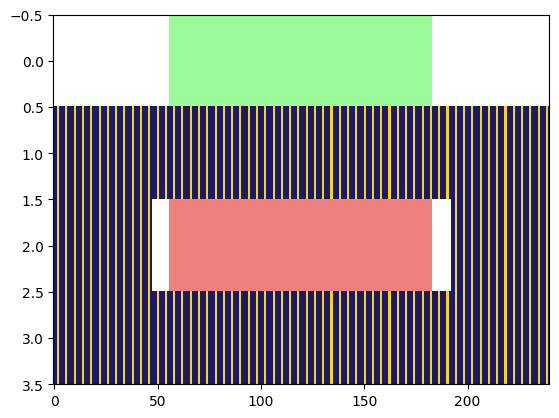

In [10]:
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)
fig = ssbObject.displayGrid(option=1)

### Mapping SSB to Transmission Grid for ODFM

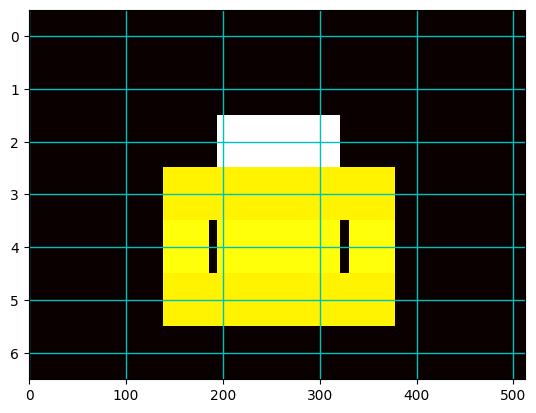

In [11]:
## Loading SSB to SSB Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = carrierFrequency, N_RB=nRB,
                              kssb=int(ssbSubCarrierOffset), offsetToPointA = int(nRB*0.5-10),
                              scsCarrier = subCarrierSpacingCommon,
                              ssbPositionInBurst = ssbPositionInBurst, ssbPeriodicity = None, nHF=None,
                              nFrames = 0.1*nFrames, isPairedBand = isPairedBand, 
                              withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid     = ssbRGobject(ssb[0])


## Loading SSB to Resource Grid
numofGuardCarriers = (int((Nfft - Neff)/2), int((Nfft - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = ssbRGobject.numSymbols

X = np.zeros((numOFDMSymbols, Nfft), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
# Gridlines based on minor ticks
plt.show()

### OFDM-Modulator
OFDM Modulator process the transmission grid column by column and performs following operations on each column:
- Fetch a column of the transmission grid
    - Size of each column is $\text{N}_\text{FFT}$.
- IFFT Shift
- IFFT Transform
- Add cyclic prefix

![OFDMModulator](images/OFDM_Tx.svg)


In [12]:
## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X)[np.newaxis, np.newaxis, np.newaxis, ...]
#______________________________________________________

### Analog Beamforming
- Input
    - Beamforming Direction ($\theta, \phi$): ``bfAngle``
    - Transmit Power, $P_t$ (dBm): ``Pt_dBm``
    - Transmit Signal, $x(t)$: ``x_time``
- Analog Beamformer Object: ``aBF``
- Output:
    - Beamformed Signal: ``x_Beam``

In [13]:
## Analog Beamforming at Transmitter
#####################################
# Beamforming Parameters
# Number of antennas for Beamforming
# Beamforming angles

# Total Transmit Power
Pt_dBm = 43;  # dBm
Pt_a   = 10**((Pt_dBm-30)/10)
bfAngle= np.array([0, 0])

# nSymbforScheduling = startOFDMSymbolIndices[-1]*Nfft;
nSymbforScheduling = x_time.shape[-1]

x_Beam = np.zeros([x_time.shape[0], x_time.shape[1], Nt_x*Nt_y*Pt, 
                   nSymbforScheduling], dtype = np.complex64)

isCustomBeamformer = False
aBF                = AnalogBeamforming(carrierFrequency, isCustomBeamformer)
for nbatch in range(x_time.shape[0]):
    for ntx in range(x_time.shape[1]):
        x_Beam[nbatch, ntx, :, :] = aBF(x_time[nbatch][ntx][:,:], Pt_dBm, bfAngle,
                                        np.array([lamda/2, lamda/2]), np.array([Nt_x, Nt_y, Pt]))

## Channel Generation


*****************************************************
                   Terrain: UMa
             Number of UEs: 1
             Number of BSs: 1
*****************************************************



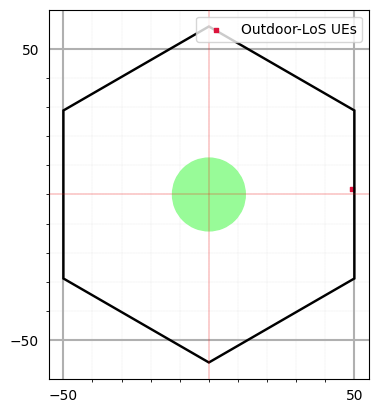

             Number of BSs: 1
          Shape of Channel: (1, 1, 1, 1, 512, 8, 128)
*****************************************************



In [14]:
propTerrain      = "UMa"       # Propagation Scenario or Terrain for BS-UE links

print()
print("*****************************************************")
print("                   Terrain: "+str(propTerrain))
print("             Number of UEs: "+str(numUEs))
print("             Number of BSs: "+str(numBSs))
print("*****************************************************")
print()

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1, 1, Nr_x, Nr_y, Pr]))
ueAntArray()

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1, 1, Nt_x, Nt_y, Pt]))
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 100        # inter site distance
minDist              = 10          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 1           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
# forceLOS             = True       # boolen flag if true forces every link to be in LOS state
forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = numBSs,
                                numOfUE = numUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain, 
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()

paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft)
htime   = np.fft.ifft(Hf, norm="ortho", n=Nfft, axis = -3)

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

print("             Number of BSs: "+str(numBSs))
print("          Shape of Channel: "+str(htime.shape))
print("*****************************************************")
print()

## Pass Tx signal through Wireless Channel

In [15]:
# Channel Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs, numUEs, numSamples/numFFTpoints, numRxAntennas, numTxAntennas
# Tx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs,         numSamples/numFFTpoints,                numTxAntennas
# Rx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots),   --    numUEs, numSamples/numFFTpoints, numRxAntennas
ptc = ApplyChannel(isFrequencyDomain = False, enableInterTxInterference = True, memoryConsumptionLevel = 4)
y   = ptc(htime[np.newaxis], x_Beam.transpose(0,1,3,2)[np.newaxis, np.newaxis])
# returns y of shape: numBatch x numFreq x numSnapshots x numUEs x numSamples x numRxAntennas

In [16]:
y.shape

(1, 1, 1, 1, 5103, 8)

## Noise addition at receiver 

In [17]:
## Noise added by the Receiver
k_Bolt         = 1.380649*(10**(-23));
Temp           = 300;
Bandwidth      = Nsc_ssb*scs;
n0             = k_Bolt*Temp*Bandwidth
kppm           = 0
fCFO           = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
CFO            = (fCFO/scs)/Nfft
yn             = AddNoise(True)(y, n0, CFO)

## SSB Receiver Side
Receiver side implements the following procedures for downlink synchronization:
- Receiver Combining
- Time Synchronization.
    - Raster Search
    - Finding OFDM symbol boundry
    - $\text{N}_\text{ID}^\text{2}$ detection.
- Resource Grid reconstruction
    - Extract SSB Grid
- SSS Detection
    - $\text{N}_\text{ID}^\text{1}$ detection.
- DMRS Parameter estimation
    - Estimates following parameters
        - Half frame Index
        - SSB Index (lower 3 values)
- Symbol Equalization
    - Estimate PBCH Symbols
- PBCH Decoding
    - Decode MIB parameters
    - Decode ATI Parameters
    
The detail procedure is shown below:

| |
|:--:| 
| |
| ![SSB Tranmitter side](images/PBCHReceiver.svg)| 
| *Receiver side implementation of SSB* |


<br/><br/>

### Receiver combining

In [18]:
## Receiver combiner Object 
# angles         = np.array([[0, -70]])
angles         = np.zeros([90,2])
angles[:,1]    = np.linspace(0,360, 90)
spacing        = np.array([lamda/2, lamda/2])
rxArray        = np.array([Nr_x, Nr_y, Pr])
rxCombining    = ReceiveCombining(combinerType = "dft", numDFTBeams = 16, output = "best")
r              = rxCombining(yn)

### PSS Detection: largest peak

In [19]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1], 
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((Nfft-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(r, Nfft, lengthCP = lengthCP[1], 
                                                                  N_ID2 = None, freqOffset = ssboffset)

**(rasterOffset, PSS-ID) (138, 0)
**(rasterOffset, PSS-ID) (138, 1)
**(rasterOffset, PSS-ID) (138, 2)


### Largest peak

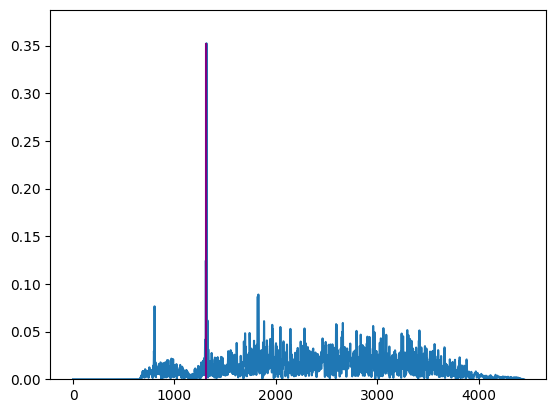

In [20]:
## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

# single line
plt.plot(pssCorrelation)
plt.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
plt.ylim([0,np.max(pssCorrelation)*1.1])
plt.show()
#________________________________________________________________

### OFDM Demodulation: Resource Grid reconstruction
OFDM Demodulator process a block of data and performs following operations on each column:
- Fetch a ($\text{N}_\text{FFT} + \text{L}_\text{CP}$) samples from the received sequence.
- Remove the cycle prefix $\text{L}_\text{CP}$ samples
- Perform FFT Transform on remaining $\text{N}_\text{FFT}$ samples 
- Insert these samples into the columns of a grid.
![OFDMDemodulator](images/OFDM_Rx.svg)


In [21]:
## OFDM Demodulator Object 
ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
pssStartIndex   = pssPeakIndices
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator(r[...,pssStartIndex:(pssStartIndex+4*(Nfft+lengthCP[1]))])[0,0,0,0]

In [22]:
rxGrid.shape

(4, 512)

### SSB Extaction from Resource Grid

In [23]:
ssbSCSoffset   = int((Nfft-Neff)/2+ssbRGobject.startingSubcarrierIndices)
ssbEstimate    = rxGrid[...,ssbSCSoffset:(ssbSCSoffset+240)]

### Comparing Transmitted and Received SSB Grid

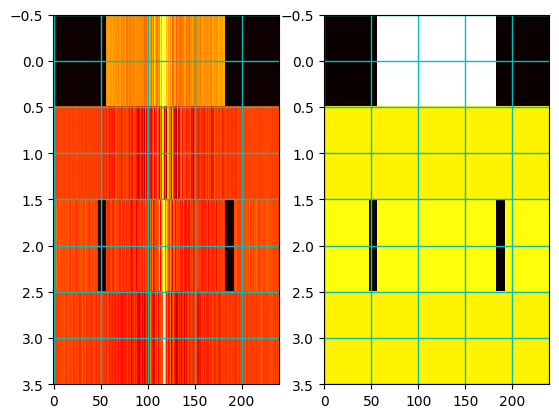

In [24]:
# Plot SSB
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(ssbEstimate), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[0].grid(color='c', linestyle='-', linewidth=1)

ax[1].imshow(np.abs(ssb[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[1].grid(color='c', linestyle='-', linewidth=1)

plt.show()

### Spectrum Analysis

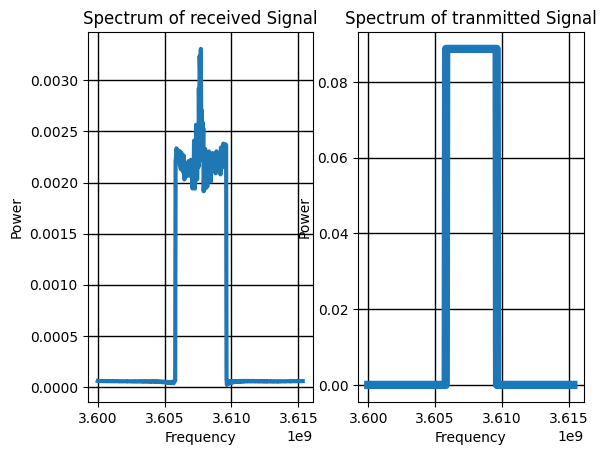

In [25]:
# Plot SSB
fig, ax = plt.subplots(1,2)
ax[0].plot(np.arange(rxGrid.shape[-1])*subCarrierSpacingCommon + carrierFrequency, np.abs(rxGrid[0]), lw = 3)
ax[0].grid(color='k', linestyle='-', linewidth=1)
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Power")
ax[0].set_title("Spectrum of received Signal")

ax[1].plot(np.arange(X.shape[-1])*subCarrierSpacingCommon + carrierFrequency, np.abs(X[ssbRGobject.startingSymbolIndices[0]]), lw = 6)
ax[1].grid(color='k', linestyle='-', linewidth=1)
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Power")
ax[1].set_title("Spectrum of tranmitted Signal")

plt.show()

### (SSS Detection: PSS channel assisted) + Cell-ID estimation

In [26]:
sssDetection   = SSSDetection(method="channelAssisted", N_ID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate)
rN_ID          = 3*rN_ID1 + rN_ID2

### DMRS Parameters Detection + DMRS Sequence Generation

In [27]:
## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf, dmrsLen)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate)
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

### Channel Estimation and PBCH Symbol Equalization
The following steps are performed:
- Channel Estimation 
- Symbol Equalization

The details of the  implementation is as follow:

|Parameters | Values
| :--- | :--- 
|Channel Estimator | Zeros forcing
|Channel Interpolation | Nearest Neighbour
|Symbol Equalization | Minimum mean square error

In [28]:
## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
rxPBCHIndices  = rxSSBobject.pbchIndices
pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq[0], rxDMRSIndices, rxPBCHIndices)

## Constellation Diagram: Rx

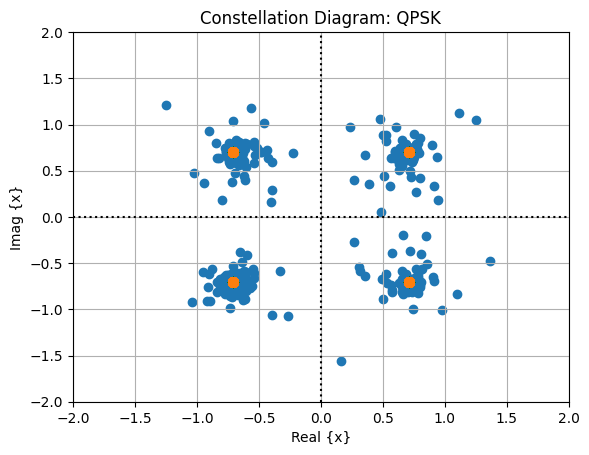

In [29]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

### PBCH Decoding
PBCH decoder extract the MIB and ATI payload bits from the estimated/equalized symbols. 

Implementation of PBCH is detailed below:

![PBCHRxChain](images/PBCHChain.svg)



In [30]:
## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "maxlog"
# extractMIBinfo = False
extractMIBinfo = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder    = PBCHDecoder(carrierFrequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, Pt_a/n0, extractMIBinfo)

/home/tenet/Downloads/Packages/5G_Toolkit/version12/Tutorials/Simulations/Tutorial-5 [SSB]/../../../toolkit5G/ChannelCoder/PolarCoder/polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


In [31]:
if(np.all(check)):
    print("[Hurray]: CRC-check passed!")
else:
    print("[Ohh]: CRC-check failed!")

[Hurray]: CRC-check passed!


### Information Aggregation

In [32]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	3600000000.0
ChoiceBit:  		0
nSsbCandidatesInHrf: 	8
subCarrierSpacingCommon:30000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	1
searchSpace0: 		13
cellBarred: 		barred
intraFreqReselection: 	notAllowed
systemFrameNumber: 	644
ssbSubCarrierOffset: 	2
HRFBit: 		0
iSSBindex: 		0


In [33]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	3600000000.0
ChoiceBit:  		0
nSsbCandidatesInHrf: 	8
subCarrierSpacingCommon:30000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	1
searchSpace0: 		13
cellBarred: 		barred
intraFreqReselection: 	notAllowed
systemFrameNumber: 	644
ssbSubCarrierOffset: 	2
HRFBit: 		0
iSSBindex: 		0


## Performance Evaluations: BER + Cell-IDs + DMRS Parameter Detection

### Cell-IDs Detection

In [34]:
if (rN_ID == N_ID):
    print("[Success]: Cell-IDs correctly detected!")
else:
    if (rN_ID1 != N_ID1 and rN_ID2 != N_ID2):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 and cell-ID2 correctly!")
    elif(rN_ID1 != N_ID1):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 correctly!")
    else:
        print("[Failed]: Receiver couldn't detect the cell-ID2 correctly!")

[Success]: Cell-IDs correctly detected!


In [35]:
rN_ID1, N_ID1

(3, 3)

### DMRS Parameter Detection

In [36]:
if (rssbIndex == ssbIndex[0]):
    print("[Success]: DMRS parameters correctly detected!")
else:
    print("[Failed]: Receiver couldn't detect the ssbIndex correctly!")

[Success]: DMRS parameters correctly detected!


### BER computation

In [37]:
## Computing BER: Coded and Uncoded
uncodedBER     = np.zeros((numUEs, nBatch))
codedBER       = np.zeros((numUEs, nBatch))

bitEst         = pbchDecoder.llr.copy()
bitEst[pbchDecoder.llr  > 0]   = 1
bitEst[pbchDecoder.llr  < 0]   = 0
uncodedBER = np.mean(np.abs(bitEst - pbchObject.scr2bits[0]))
codedBER   = np.mean(np.abs(pbchDecoder.pbchResequenceBits - pbchObject.payloadMIB[0]))

print(" (uncoded-BER, codedBER): "+str((uncodedBER, codedBER)))

 (uncoded-BER, codedBER): (0.004629629629629629, 0.0)
